In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.ornstein_uhlenbeck import OrnsteinUhlenbeck
from rivapy.models import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.pricing.green_ppa_pricing import price
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
import numpy as np
from scipy.special import comb

%load_ext autoreload
%autoreload 2
%matplotlib inline

../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
../../rivapy/pricing/green_ppa_pricing.py:7: UserWarning: Tensorflow is not installed. You cannot use the PPA pricer!
  warnings.warn('Tensorflow is not installed. You cannot use the PPA pricer!')


# Models

In [2]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
    result *= x ** (N + 1)
    return result

def _logit(x):
    return np.log(x/(1-x))

def _inv_logit(x):
    return 1.0/(1+np.exp(-x))


class SmoothstepSupplyCurve: 
    def __init__(self, s,N):
        self.s = s
        self.N = N
        
    def compute(self, residual, highest_price):
        #wind_production = wind_production#np.maximum(np.minimum(wind_production, 0.99), 0.01)
        #residual = (1.0-wind_production)
        residual = np.power(residual, self.s)
        return smoothstep(residual, N=self.N)*highest_price


- $p(t,T)$: Forward-Price zum Zeitpunkt $t$ mit Expiry $T$
- $f_i(t,T)$: Forecast der i-ten Technology für $T$ zum Zeitpunkt $t$
    - Annahme: Forecast stueckweise Konstant in der Zeit (Sprung an Forecast Terminen)


Wuenschenswert:
- $f_i(t,T)=E\left[f_i(T,T)\mid f_i(t,T)\right]$
- $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$

Einfache Moeglichkeit (ohne die wuenschenswerten Punkte einzuhalten): 
- $c(t,T)$: Hoechster Preis, der aufgrund der Angebotskurve zustande kommen kann
- $r(x)$: Residual demand curve mit Werten zwischen 0 und 1
$$
p(t,T) = c(t,T)\cdot r(1.0 - \sum_i f_i(t,T))
$$
Unabghängigkeit von $c$ und $f_i$:
$$
E\left[p(T,T)\right] = E\left[c(T,T)\right]E\left[r(1.0 - \sum_i f_i(T,T))\right]
$$
und wenn 
$$E\left[c(T,T))\right]=c(t,T)$$ 
und 
$$E\left[r(1.0 - \sum_i f_i(T,T)\right]=r(1.0 - \sum_i f_i(t,T))$$
haben wir $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$. Wenn $r$ linear, d.h. $r(x)=x$ dann einfach!


$$
dF = \lambda(F-a-r(f))dt + \sigma dW
$$

In [3]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1] + 10*24*i/(365*24.0) for i in range(4)]
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=1.0, volatility=0.30, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )

rnd = np.random.normal(size=wind_forecast_model.rnd_shape(n_sims, timegrid.shape[0]))
wind = wind_forecast_model.simulate(timegrid, rnd)

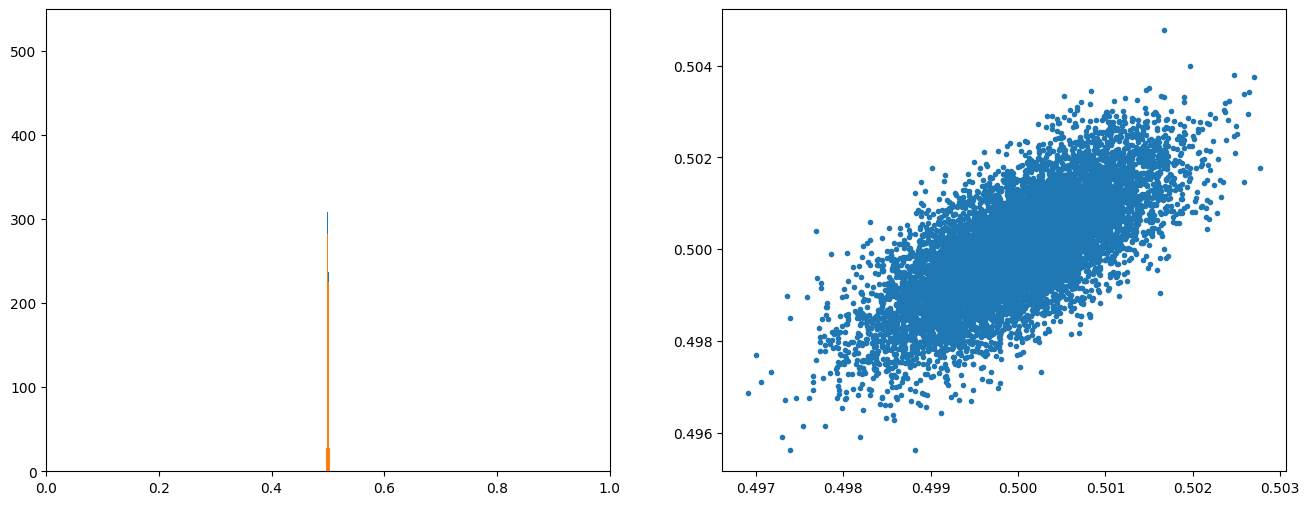

In [4]:
expiry1 = 1
expiry2 = 2#5*24
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(_inv_logit(wind._paths[expiry1,:]), density=True, bins=100)
plt.hist(_inv_logit(wind._paths[expiry2,:]), density=True, bins=100)
plt.xlim(0.0,1.0)
plt.subplot(1,2,2)
plt.plot(_inv_logit(wind._paths[expiry1,:]), _inv_logit(wind._paths[expiry2,:]), '.');

In [5]:
wind_forecast_model_2 = WindPowerForecastModel(speed_of_mean_reversion=2.0, volatility=0.6, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )
region_wind_model = MultiRegionWindForecastModel([(0.5, wind_forecast_model, [0.6, 0.4]),
                              (0.5, wind_forecast_model_2, [0.4, 0.6])])

In [6]:
results = region_wind_model.simulate(timegrid, rnd)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
expiry = -1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(_inv_logit(results[0]._paths[expiry,:]), _inv_logit(results[1]._paths[expiry,:]), '.');

plt.subplot(1,2,2)
plt.hist(_inv_logit(results[0]._paths[expiry,:]), density=True, label='region 0', bins=100)
plt.hist(_inv_logit(results[1]._paths[expiry,:]),  density=True, label='region 1', bins=100, alpha=0.8);


In [ ]:
for fwd in [0,-1]:#range(wind.n_forwards()):
    fwd_values = wind.get_fwd(0, fwd)
    plt.hist(fwd_values, bins=100, label='expiry ' + str(wind.expiry(fwd))[:6], alpha=0.3, density=True)
plt.legend();

In [ ]:
timestep = 20
fwd1 = 0
fwd2 = 1
fwd_values1 = wind.get_fwd(timestep, fwd1)
fwd_values2 = wind.get_fwd(timestep, fwd2)
plt.plot(fwd_values1, fwd_values2, '.', alpha=0.1)
plt.legend();

In [ ]:

class ResidualDemandForwardModel:
        
    def __init__(self, wind_power_forecast, highest_price_ou_model, supply_curve):
        self.wind_power_forecast = wind_power_forecast
        self.highest_price_ou_model = highest_price_ou_model
        self.supply_curve = supply_curve
        
    def simulate(self, timegrid, rnd, forecast_timepoints, highest_price):
        highest_prices = self.highest_price_ou_model.simulate(timegrid, 1.0, rnd[0,:])*highest_price
        wind = self.wind_power_forecast.simulate(timegrid, rnd[1,:])._paths
        result = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_forwards()))
        current_forecast_residual = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_forwards()))
        for i in range(timegrid.shape[0]):
            for j in range(self.wind_power_forecast.n_forwards()):
                if i in forecast_timepoints:
                        current_forecast_residual[i,:,j] = 1.0-self.wind_power_forecast.get_forward(wind[i,:], timegrid[i],j)
                else:
                    current_forecast_residual[i,:,j] = current_forecast_residual[i-1,:,j]
            for j in range(self.wind_power_forecast.n_forwards()):
                result[i,:,j] =  self.supply_curve.compute(current_forecast_residual[i,:,j], highest_prices[i,:] )
        return result, current_forecast_residual

In [ ]:
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, highest_price, supply_curve)

In [ ]:
n_sims = 1000
rnd = np.random.normal(size=(2,timegrid.shape[0], n_sims))
fwd_prices, fwd_residuals = rdm.simulate(timegrid, rnd, forecast_points, highest_price=1000)

In [ ]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])[:6]
    color = None
    for i in range(100):
        lines = plt.plot(timegrid, fwd_prices[:,i,T], '-', alpha=0.1, label=label, color = color)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$p(t,T)$')
plt.legend()
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)
plt.subplot(1,3,2)
x = np.linspace(0.0,1.0,50)
plt.plot(x,rdm.supply_curve.compute(x, 1000))
plt.xlabel('residual demand')
plt.ylabel('price')
plt.subplot(1,3,3)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])
    color = None
    for i in range(100):
        plt.plot(timegrid, 1.0-fwd_residuals[:,i,T], '-', color = color, alpha=0.1)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$f_i(t,T)$')
plt.legend();

In [ ]:
plt.figure(figsize = (16,4))

for T in [0,1,2]:
    plt.subplot(1,3,T+1)
    label = 'T='+str(forward_expiries[T])[:6]
    plt.plot( 1.0-fwd_residuals[-1,:,T], fwd_prices[-1,:,T], '.', alpha=0.1, label=label)
    label=None
plt.ylabel('$p(T,T)$')
plt.xlabel('$f_i(T,T)$')
plt.legend();

In [ ]:
fwd_prices[-1,:,T].shape

In [ ]:
for i in range(100):
    plt.plot(timegrid, result[:,i,-2], '-b', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)

In [ ]:
wind = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=[1.0+i/(365.0*24.0) for i in range(24)],
                            forecasts = [0.8-i*0.4/23.0 for i in range(24)])

timegrid = np.linspace(0.0, 1.0, 100)
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = wind.simulate(timegrid, rnd)

expiry = 0
timepoint = 99
t = timegrid[timepoint]
fwd = wind.get_forward(paths[timepoint], t, expiry)
print(np.mean(fwd))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(fwd, bins = 100);
plt.subplot(1,2,2)
plt.plot(paths[timepoint], fwd,'.');

In [ ]:

timepoint = -1
forecast = 0.001
ou = OrnsteinUhlenbeck(speed_of_mean_reversion=0.20, volatility=0.4, mean_reversion_level=0.0)
timegrid = np.linspace(0.0, 1.0, 100)
#scaling = 
correction = _logit(forecast)-ou.compute_expected_value(0.0, timegrid[timepoint])

print(_inv_logit(ou.compute_expected_value(0.0, timegrid[timepoint])+correction))
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = ou.simulate(timegrid, 0.0, rnd) + correction
paths_inv_logit = _inv_logit(paths)

#plt.hist(paths[-1,:], bins=100)
plt.hist(paths_inv_logit[timepoint,:], bins=100);
print('mean ou path ', np.mean(paths[timepoint,:]), 'inverse_logit of mean ',_inv_logit(np.mean(paths[timepoint,:])), 
      ' mean of inverse logit',np.mean(paths_inv_logit[timepoint,:]))

_logit(forecast)

## MultiRegionWindForecastModel

In [35]:
from rivapy.models.residual_demand_model import MultiRegionWindForecastModel
forward_expiries = [24.0*2/365.0]
regions = [ MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Onshore'
                                                            ),
                                    capacity=1000.0,
                                    rnd_weights=[0.7,0.3]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Offshore'
                                                            ),
                                    capacity=500.0,
                                    rnd_weights=[0.3,0.7]
                                )
           
          ]
days = 2 
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
multi_region_model = MultiRegionWindForecastModel(regions)
rnd = np.random.normal(size=multi_region_model.rnd_shape(1000, timegrid.shape[0]))
results = multi_region_model.simulate(timegrid, rnd)

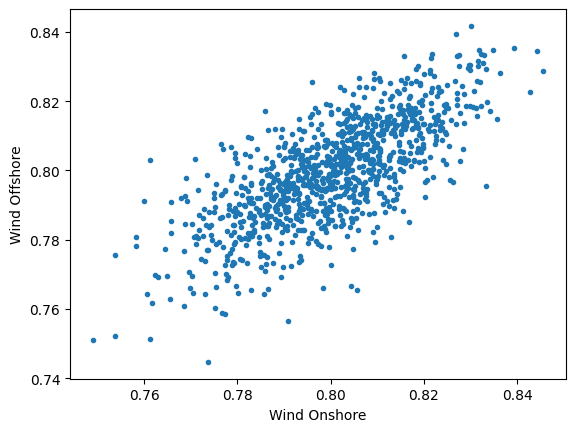

In [36]:
paths_1 = results['Onshore'].get_fwd(-1,-1)
paths_2 = results['Offshore'].get_fwd(-1,-1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');

In [53]:
rdm = ResidualDemandForwardModel(multi_region_model, 
                                 highest_price,
                                SmoothstepSupplyCurve(1.0, 0),
                                 max_price = 1.0,
                                 #forecast_hours=[#6, 
                                 #                10, 14, 18], 
                                )
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 1_000
rnd = np.random.normal(size=rdm.rnd_shape(n_sims, timegrid.shape[0]))
power_fwd, efficiencies = rdm.simulate(timegrid, rnd, forecast_points)

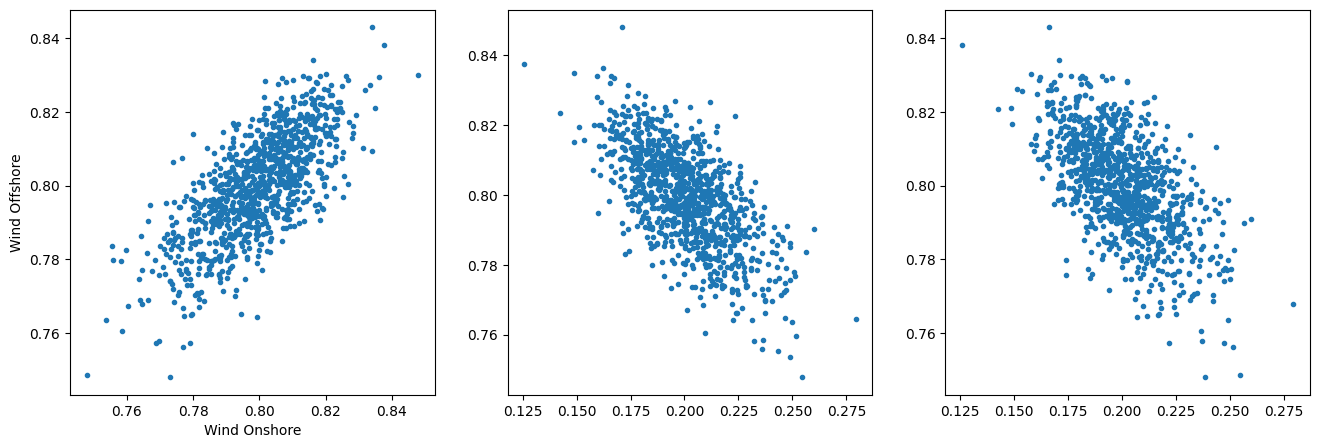

In [54]:
plt.figure(figsize=(16,5))
paths_1 = efficiencies['Onshore'][-1,:,-1]
paths_2 = efficiencies['Offshore'][-1,:,-1]
plt.subplot(1,3,1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');
plt.subplot(1,3,2)
plt.plot(power_fwd[-1,:,-1],paths_1,'.')
plt.subplot(1,3,3)
plt.plot(power_fwd[-1,:,-1],paths_2,'.');

# Hedging

In [11]:

val_date = dt.datetime(2023,1,1)
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 1_000

wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=0.5, volatility=1.80, 
                            expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            region = 'Onshore'
                            )
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, 
                                 highest_price,
                                 supply_curve,
                                 max_price = 1.0,
                                 forecast_hours=[#6, 
                                                 10, 14, 18], 
                                #region_to_capacity=None
                                )

../../rivapy/pricing/green_ppa_pricing.py:7: UserWarning: Tensorflow is not installed. You cannot use the PPA pricer!
  warnings.warn('Tensorflow is not installed. You cannot use the PPA pricer!')


In [12]:
strike = 0.2#fwd_prices[:,-1].mean()
spec = GreenPPASpecification(technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [36]:
tensorboard_logdir = None#os.path.join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
result = price(val_date, spec, rdm , 
               depth=3, nb_neurons=64, 
               n_sims = n_sims, regularization= 10.0, 
              epochs = 200, 
              verbose=1, 
              initial_lr = 1e-2,
              batch_size=200,
              decay_rate=0.7,
              tensorboard_logdir=tensorboard_logdir
            )

Epoch 1/200
5/5 [==============================] - 0s 64ms/step - loss: 0.0482
Epoch 2/200
5/5 [==============================] - 0s 71ms/step - loss: 0.0036
Epoch 3/200
5/5 [==============================] - 0s 72ms/step - loss: 0.0037
Epoch 4/200
5/5 [==============================] - 0s 69ms/step - loss: 0.0018
Epoch 5/200
5/5 [==============================] - 0s 79ms/step - loss: 0.0011
Epoch 6/200
5/5 [==============================] - 0s 72ms/step - loss: 4.0608e-04
Epoch 7/200
5/5 [==============================] - 0s 58ms/step - loss: 1.7180e-04
Epoch 8/200
5/5 [==============================] - 0s 69ms/step - loss: 2.4806e-04
Epoch 9/200
5/5 [==============================] - 0s 69ms/step - loss: 4.4472e-05
Epoch 10/200
5/5 [==============================] - 0s 64ms/step - loss: 7.5459e-05
Epoch 11/200
5/5 [==============================] - 0s 61ms/step - loss: 2.4910e-05
Epoch 12/200
5/5 [==============================] - 0s 64ms/step - loss: 2.2680e-05
Epoch 13/200
5/5 [===

5/5 [==============================] - 0s 64ms/step - loss: 1.1521e-06
Epoch 99/200
5/5 [==============================] - 0s 77ms/step - loss: 1.1414e-06
Epoch 100/200
5/5 [==============================] - 0s 74ms/step - loss: 1.1471e-06
Epoch 101/200
5/5 [==============================] - 0s 74ms/step - loss: 1.1308e-06
Epoch 102/200
5/5 [==============================] - 0s 79ms/step - loss: 1.1217e-06
Epoch 103/200
5/5 [==============================] - 0s 69ms/step - loss: 1.1526e-06
Epoch 104/200
5/5 [==============================] - 0s 77ms/step - loss: 1.1254e-06
Epoch 105/200
5/5 [==============================] - 0s 70ms/step - loss: 1.1419e-06
Epoch 106/200
5/5 [==============================] - 0s 70ms/step - loss: 1.1584e-06
Epoch 107/200
5/5 [==============================] - 0s 68ms/step - loss: 1.1599e-06
Epoch 108/200
5/5 [==============================] - 0s 78ms/step - loss: 1.1347e-06
Epoch 109/200
5/5 [==============================] - 0s 78ms/step - loss: 1.1221

5/5 [==============================] - 0s 64ms/step - loss: 1.0858e-06
Epoch 195/200
5/5 [==============================] - 0s 64ms/step - loss: 1.0995e-06
Epoch 196/200
5/5 [==============================] - 0s 61ms/step - loss: 1.0865e-06
Epoch 197/200
5/5 [==============================] - 0s 55ms/step - loss: 1.0842e-06
Epoch 198/200
5/5 [==============================] - 0s 62ms/step - loss: 1.0824e-06
Epoch 199/200
5/5 [==============================] - 0s 71ms/step - loss: 1.0809e-06
Epoch 200/200
5/5 [==============================] - 0s 73ms/step - loss: 1.0955e-06


In [25]:
fwd_prices.shape

(1000, 48)

strike 0.2
-0.00039803803526995056
-0.0003915445420772327


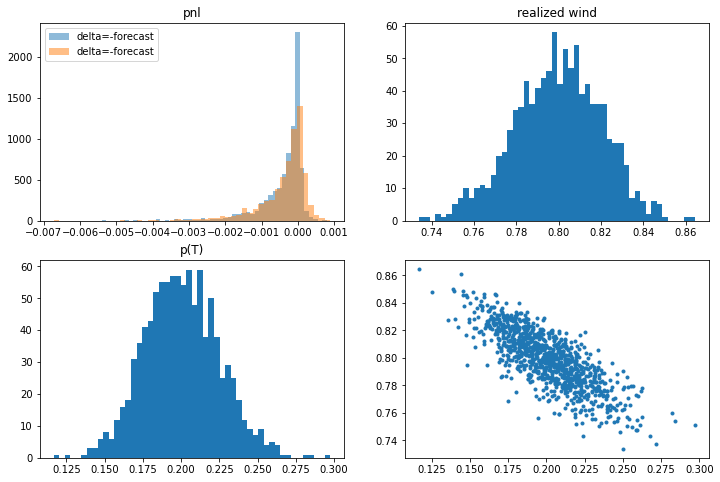

In [71]:
plt.figure(figsize=(12,8))
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
fwd_prices = result.fwd_prices
forecasts = result.forecasts

print('strike', strike)
plt.subplot(2,2,1)
#print('hedge_delta', (-fwd_residuals[-1]+1.0))
pnl_no_hedge = (fwd_prices[:,-1]-strike)*forecasts[:,-1]
#bins = plt.hist(pnl_no_hedge, bins=50, label='no hedge', density=True)
delta = -1.0*forecasts[:,0]
pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
print(pnl_hedge.mean())
delta = -0.98*forecasts[:,0]
pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
print(pnl_hedge.mean())

pnl_hedge_dynamic_volume = -fwd_prices[:,0]*forecasts[:,0]
for i in range(1,fwd_prices.shape[1]):
    pnl_hedge_dynamic_volume += 0.0*(forecasts[:,i-1]-forecasts[:,i])*fwd_prices[:,i]
pnl_hedge_dynamic_volume += 0.0*forecasts[:,-2]*fwd_prices[:,-1] + forecasts[:,-1]*(fwd_prices[:,-1]-strike)
#plt.hist(pnl_hedge_dynamic_volume,  label='dynamic delta=-forecast', alpha=0.5, density=True, bins=50)

#delta = -0pnl_hedge_dynamic_volume8*(-fwd_residuals[0,:]+1.0)
#pnl_hedge = pnl_no_hedge + (fwd_prices[-1,:]-fwd_prices[0,:])*delta
#plt.hist(pnl_hedge,  label='delta=-0.8*forecast', alpha=0.5, density=True, bins=50)
plt.legend()
plt.title('pnl')
plt.subplot(2,2,2)
plt.hist(forecasts[:,-1], bins=50);
plt.title('realized wind')
plt.subplot(2,2,3)
plt.hist(fwd_prices[:,-1], bins=50)
plt.title('p(T)')
plt.subplot(2,2,4)
plt.plot(fwd_prices[:,-1], forecasts[:,-1],'.');

In [50]:
pnl = result.hedge_model([fwd_prices.astype(np.float32), forecasts.astype(np.float32)]).numpy()

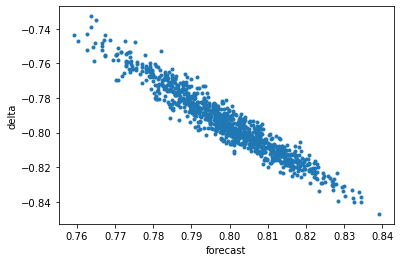

In [75]:
t = -20
delta = result.hedge_model.model.predict([fwd_prices[:,t], forecasts[:,t], np.array([timegrid[t]]*forecasts.shape[0])]).reshape((-1))
plt.plot( forecasts[:,t], delta,'.')
plt.ylabel('delta')
plt.xlabel('forecast');

0.0006804123323730954 0.0003472123
-0.0004094805798171166 -0.00039384884


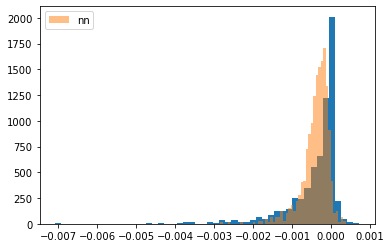

In [55]:
plt.hist(pnl_hedge, bins=50, density=True)
plt.hist(pnl, bins=50, density=True, alpha=0.5, label='nn')
plt.legend();
print(np.sqrt(pnl_hedge.var()), np.sqrt(pnl.var()))
print(pnl_hedge.mean(), pnl.mean())